# Quotes Clustering

## Using quote text to predict quote genre. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [73]:
# # Scrape the data from the Quote Garden: https://pprathameshmore.github.io/QuoteGarden/#get-a-random-quote
# d = [] # List to store the data
# for i in range(1,1001):
#     r = requests.get('https://quote-garden.herokuapp.com/api/v3/quotes',params={'page':i})
#     data = json.loads(r.content)['data']
#     d.extend(data)
# df = pd.DataFrame(d)
# df.to_csv('quotes.csv')

,Unnamed: 0,_id,quoteText,quoteAuthor,quoteGenre,__v
0,0,5eb17aadb69dc744b4e70d23,Age is an issue of mind over matter. If you do...,Mark Twain,age,0
1,1,5eb17aadb69dc744b4e70d24,"Anyone who stops learning is old, whether at t...",Henry Ford,age,0
2,2,5eb17aadb69dc744b4e70d25,Wrinkles should merely indicate where smiles h...,Mark Twain,age,0
3,3,5eb17aadb69dc744b4e70d26,True terror is to wake up one morning and disc...,Kurt Vonnegut,age,0
4,4,5eb17aadb69dc744b4e70d27,A diplomat is a man who always remembers a wom...,Robert Frost,age,0


<AxesSubplot:xlabel='Quote Genre', ylabel='Count'>

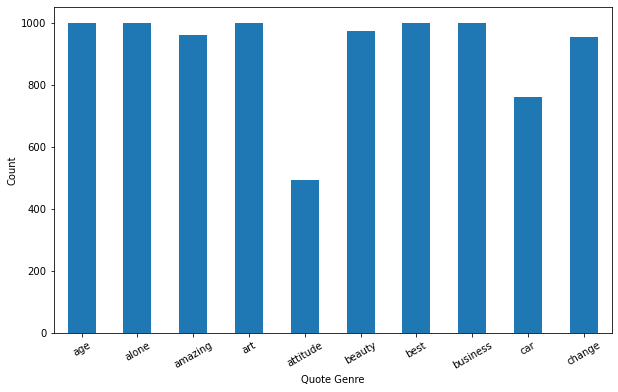

In [2]:
# Read the data
df = pd.read_csv('quotes.csv')
# Get rid of the 4 genres with lowest number of quotes
df = df[~df['quoteGenre'].isin(['anger', 'anniversary', 'architecture', 'birthday'])]
display(df.head())
plt.figure(figsize=(10,6))
df.groupby('quoteGenre')['_id'].count().plot(kind='bar', xlabel = 'Quote Genre', ylabel='Count', rot=30)

In [3]:
# Simple text preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')

def text_preprocessing(text):
    ''' 
    A function that takes in a text string and process it
    '''
    # Convert to lower case and split into a list of words
    words = text.lower().split()
    w = []

    # Get rid of non alphabetic elements, like punctuations and digits
    for word in words:
        alpha =''.join([c for c in word if c.isalpha()])
        w.append(alpha)

    # Get rid of stopwords
    w_new = [word for word in w if word not in stopwords.words('english')]

    # Lemmatize the words
    w_new  = [wnl.lemmatize(word) for word in w_new]

    # Put the words back to a string
    text_new = ' '.join(w_new)

    return text_new

In [4]:
# Example of word prcoessing
print(df.quoteText[1])
text_preprocessing(df.quoteText[1])

Anyone who stops learning is old, whether at twenty or eighty. Anyone who keeps learning stays young. The greatest thing in life is to keep your mind young.


'anyone stop learning old whether twenty eighty anyone keep learning stay young greatest thing life keep mind young'

In [5]:
# Process the text in the quote
X = df.quoteText.apply(text_preprocessing)

# Convert genre to numerical values, from high frenquency to low frenquency order
genre = {'art':1, 'business': 2, 'alone': 3, 'best':4, 'age':5, 'beauty':6, 'amazing':7, 'change':8, 'car':9, 'attitude':10}
df['Genre'] = df['quoteGenre'].apply(lambda x: genre[x])

y = df['Genre']


In [6]:
# Transform the text using tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)
X_tfidf.shape

(9136, 12196)

In [7]:
# elbow method
from sklearn.cluster import KMeans
K = range(1,30)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10).fit(X_tfidf)
    distortions.append(kmeans.inertia_)
  

Text(0.5, 1.0, 'Distortions vs. k')

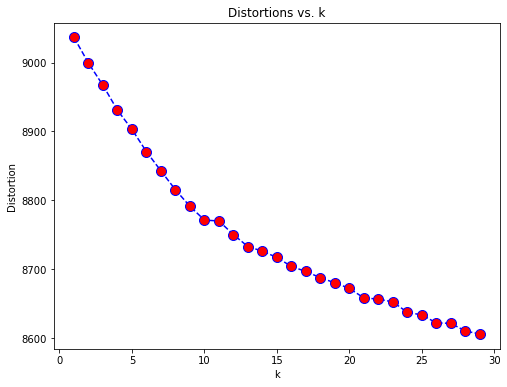

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(K, distortions, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
#plotting the both K range and then the actual distances 
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Distortions vs. k')


In [9]:
from sklearn.metrics import silhouette_score

K = range(2,30)
silhouette = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10).fit(X_tfidf)
    labels = kmeans.predict(X_tfidf)
    silhouette.append(silhouette_score(X_tfidf, labels))
  

Text(0.5, 1.0, 'Silhouette score vs. k')

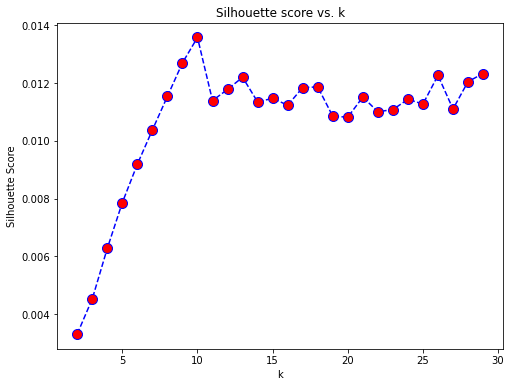

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
#plotting the both K range and then the actual distances 
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score vs. k')

# k =10 has the best Silhouette score

In [11]:
# Cluster the model into 14 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=10)
kmeans.fit(X_tfidf)

KMeans(n_clusters=10, random_state=10)

<AxesSubplot:>

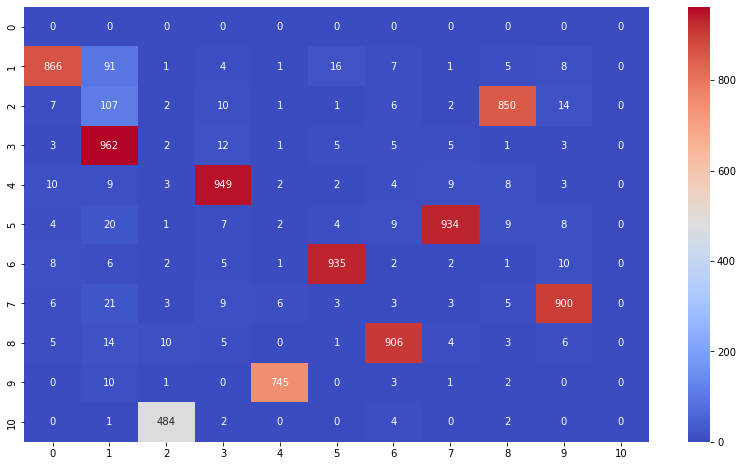

In [12]:
# The confusion matrix before matching the clusters with the labels
y_pred = kmeans.predict(X_tfidf)
plt.figure(figsize=(14,8))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap='coolwarm',fmt='d')


The accuracy score is: 0.9337784588441331 



<AxesSubplot:>

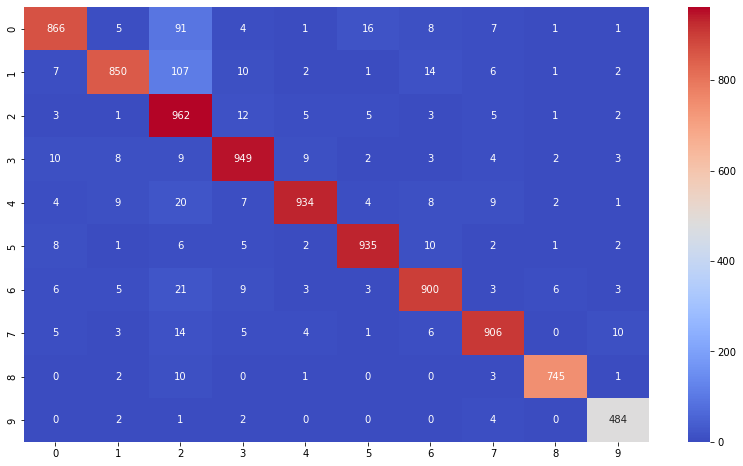

In [24]:
# Match the predicted labels with real genre labels
y_pred = kmeans.predict(X_tfidf)
labels = kmeans.predict(X_tfidf)
from scipy.stats import mode
for i in range(14):
    ratings = (labels == i)
    y_pred[ratings] = mode(y[ratings])[0]

print(f'The accuracy score is: {accuracy_score(y,y_pred)} \n')
plt.figure(figsize=(14,8))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap='coolwarm',fmt='d')


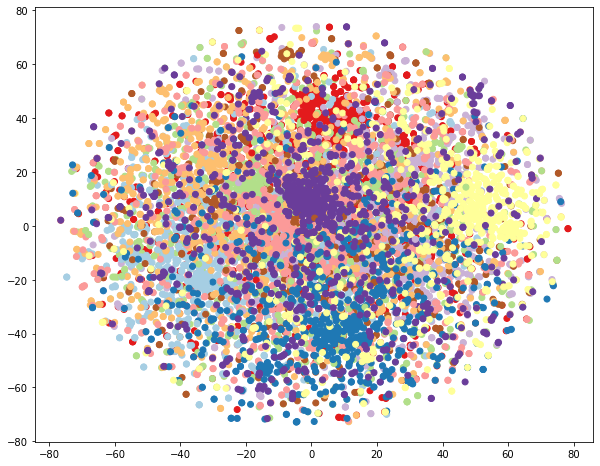

In [14]:
# # 2d visualization using t-SNE;  learning rate of 200
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, learning_rate=200) 
X_tsne = tsne.fit_transform(X_tfidf)

# PLot it out, try learning rate of 50, 70, 100, 
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, cmap="Paired")

![](2d-tSNE_image_2.png)

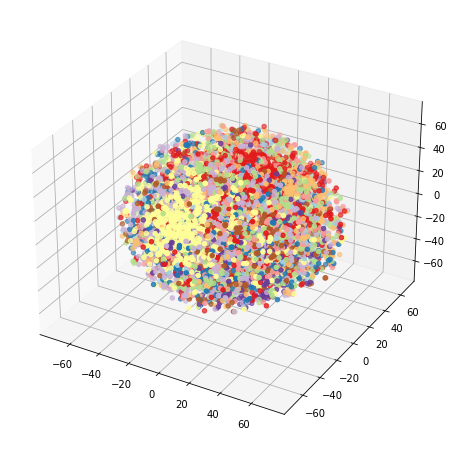

In [15]:
# 3d visualization using t-SNE
tsne3 = TSNE(n_components = 3, perplexity = 30, learning_rate=200)
X_tsne3 = tsne3.fit_transform(X_tfidf)


# Plot out 3d data
from mpl_toolkits import mplot3d
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=y_pred, cmap="Paired")



In [31]:
# Using PCA, TruncatedSVD is PCA for sparse matrix
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components= 10)
X_compressed = tsvd.fit_transform(X_tfidf)
tsvd.explained_variance_

array([0.00261614, 0.00563689, 0.00512046, 0.00497042, 0.00440822,
       0.00431084, 0.00413842, 0.00393851, 0.00344408, 0.00342556])

Text(0, 0.5, 'TruncatedSVD_component_2')

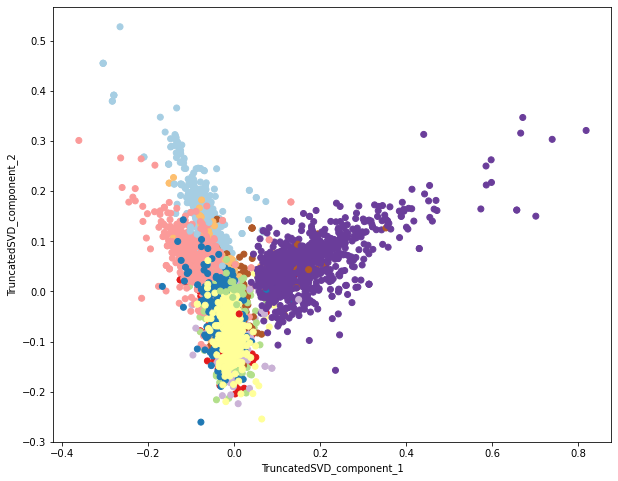

In [35]:
# 2d plot
plt.figure(figsize=(10, 8))
plt.scatter(X_compressed[:,1], X_compressed[:,2], c=y_pred, cmap="Paired")
plt.xlabel('TruncatedSVD_component_1')
plt.ylabel('TruncatedSVD_component_2')

Text(0.5, 0, 'TruncatedSVD_component_3')

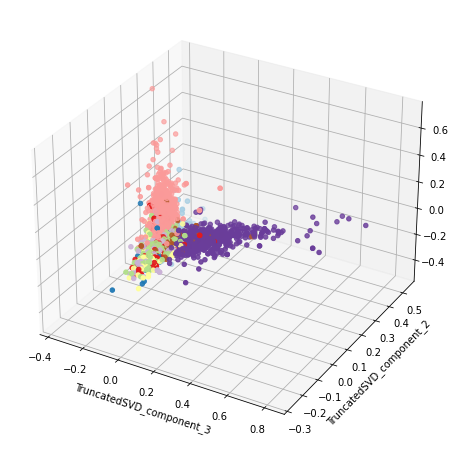

In [36]:
#3d plot
from mpl_toolkits import mplot3d
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(X_compressed[:,1], X_compressed[:,2], X_compressed[:,3], c=y_pred, cmap="Paired")
# ax.view_init(azim=10, elev=10)

## Conclusion:
### We scraped 10,000 quotes of 14 genres from a quote API, and clustered them based on the word tfidf in the quote text. By testing the clustering, we realized that removing the 4 genres with the lowest number of quotes can greatly improve the clusterting accuracy. The KMeans cluster model is able to predict 10 clusters with an accuracy of 93.4% accuracy. The plotted distortion and silhouette score also supported that 10 clusters has the best result.

### We then visualized the clusters using the t-SNE model, most of the genre clusters can be clearly distinguished in the 2d plot, but not in the 3d plot. We then used the TruncatedSVD model to reduce the dimensions. The compressed components preserved the clusters both in m2d and 3d plots.